# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Sample Code

Before you start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

In [724]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from numpy import random


In [725]:
FRAME_TIME = 0.2  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
BOOST_ACCEL2 = 0.18
DRAG_COEFF = .06
AREA = .05
AIR_DENS = .012
MASS = .1
WIND = 2
#create random initial conditions for the rocket
s1= 2 * np.random.rand()
s2= 2 * np.random.rand()
s3= 2 * np.random.rand()
s4= 2 * np.random.rand()
print(s1)
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

0.1845357528821583


In [726]:
# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        """
        
        # Apply gravity
        delta_state_gravity = t.tensor([0.,(GRAVITY_ACCEL * FRAME_TIME), 0., 0.])
        
        # Drag
        delta_state_drag = (t.tensor([0., -1., 0., 0.])*((( DRAG_COEFF * AREA * ((AIR_DENS * state[1]**2)/2))/MASS) * FRAME_TIME))
        
        # Introduce an x direction wind to the model  
        delta_state_drag_WIND = (t.tensor([0., 0., 0., 1])*((( DRAG_COEFF * AREA * ((AIR_DENS * WIND**2)/2))/MASS) * FRAME_TIME))
        
        # Thrust
        #Here i built my model around the use of 3 thrusters up, left,and right
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        delta_state_x_n = BOOST_ACCEL2 * FRAME_TIME * action[1] * t.tensor([0., 0., 0., -1.])
        delta_state_x_p = BOOST_ACCEL2 * FRAME_TIME * action[2] * t.tensor([0., 0., 0., 1.])
        
        # Update velocity
        state = state + delta_state_y + delta_state_gravity + delta_state_drag + delta_state_x_p + delta_state_drag_WIND + delta_state_x_n
        
        # Update state
        # Here we update the state vector by multiplying the velocity by time and adding the previous position for both x and y
        step_mat = t.tensor([[1., FRAME_TIME,0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1]])
        state = t.matmul(step_mat, state)

        return state
        

In [727]:
class Controller(nn.Module):
    
    def __init__(self, dim_input, dim_hidden, dim_output):
        
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(), 
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )
        
    def forward(self, state):
        action = self.network(state)
        return action

In [728]:

class Simulation(nn.Module):
    
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        
    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)
    
    @staticmethod
    def initialize_state():
        state = [s1, s2, s3, s4]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        states = state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2
        height = t.matmul(t.stack(self.state_trajectory),t.tensor([1., 0., 0., 0.]))
        position = t.matmul(t.stack(self.state_trajectory),t.tensor([0., 0., 1., 0.]))
        penalty = t.nn.functional.relu(-height).sum(dim=0)**T # introduce penalty funtion if height is less than 0
        return states + (1 * penalty)

In [729]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        self.loss_trajectory = []
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()
            loss1 = np.array([loss.detach().numpy()])
            self.loss_trajectory.append(loss1)
        plt.plot(self.loss_trajectory)
        plt.title("Convergence Plot")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
        
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        i = data[:, 2]
        j = data[:,3]
        plt.plot(x, y)
        plt.xlabel("Y Position")
        plt.ylabel("Y Velocity")
        plt.show()
        plt.plot(i, j)
        plt.xlabel("X Position")
        plt.ylabel("X Velocity")
        plt.show()
        plt.plot(i, x)
        plt.title("Rocket path")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.show()

[1] loss: 1199.017


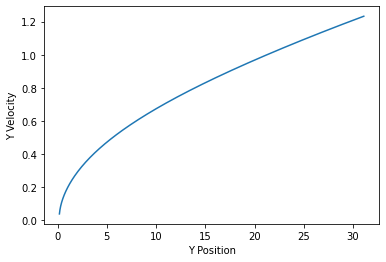

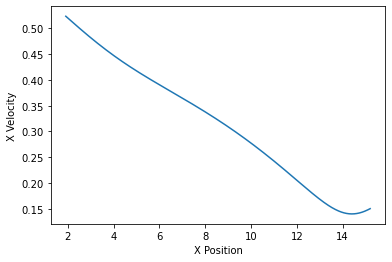

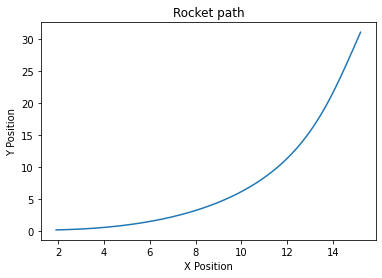

[2] loss: 519.247


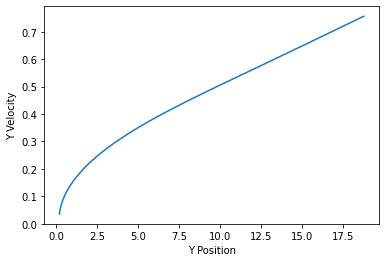

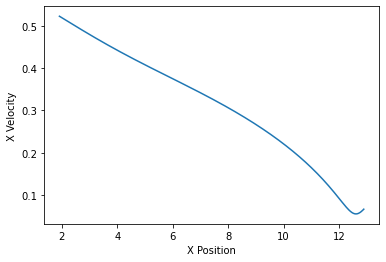

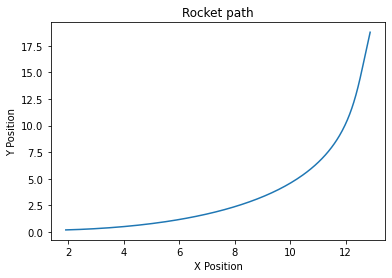

[3] loss: 243.221


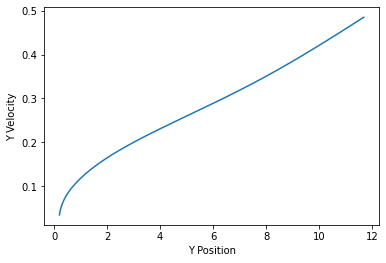

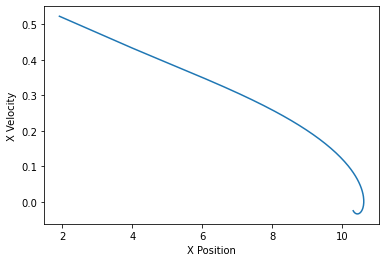

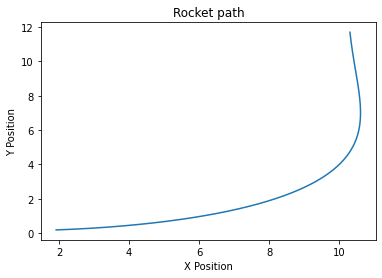

[4] loss: 63.530


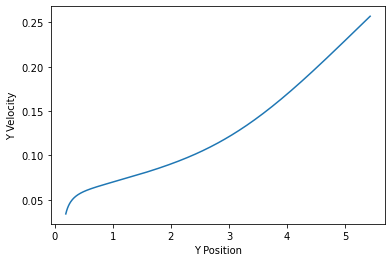

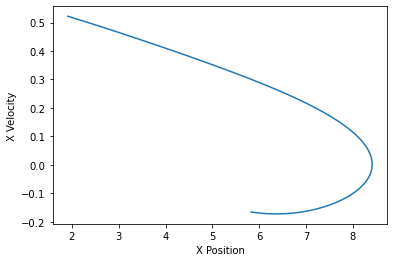

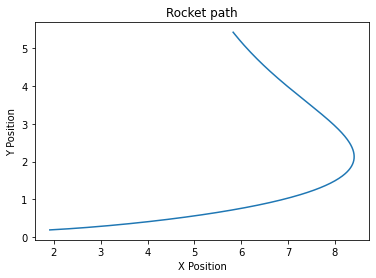

[5] loss: 10.386


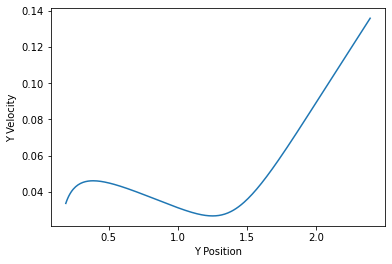

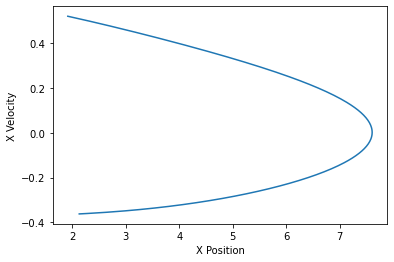

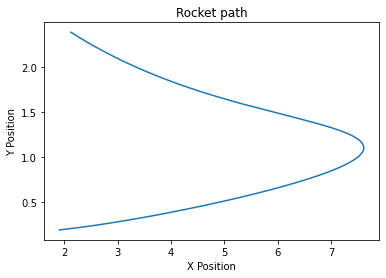

[6] loss: 5.485


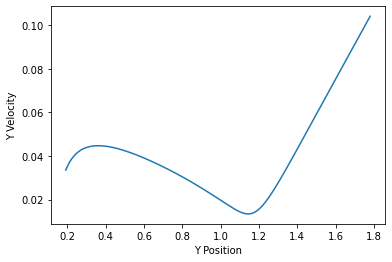

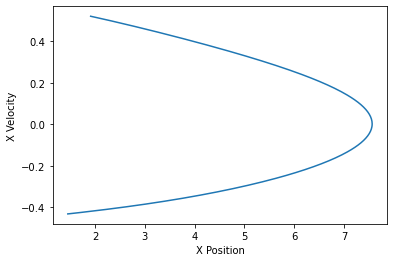

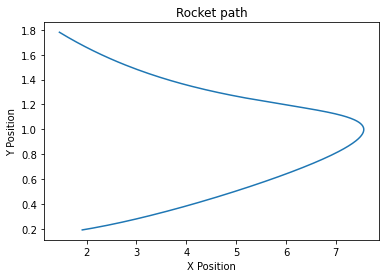

[7] loss: 3.368


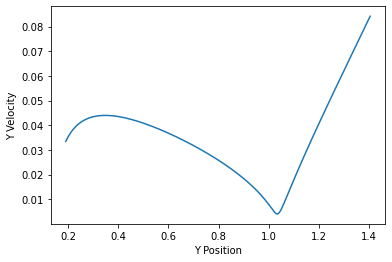

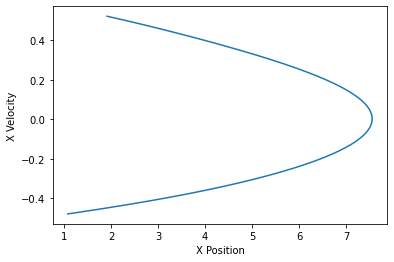

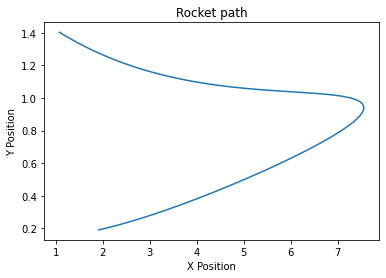

[8] loss: 2.238


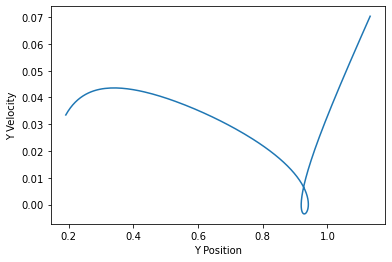

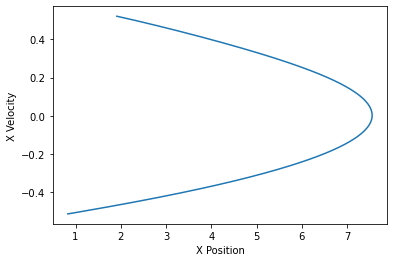

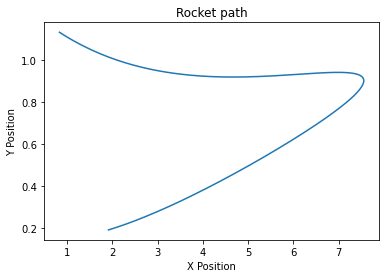

[9] loss: 1.576


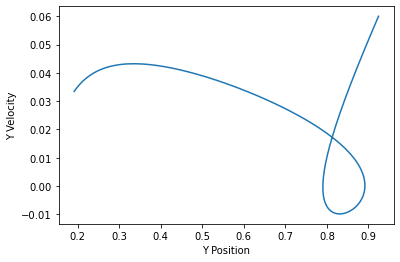

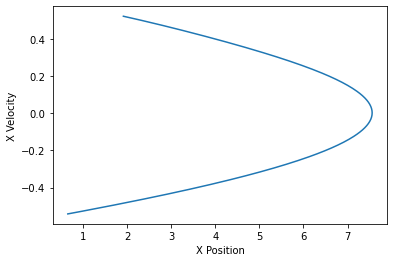

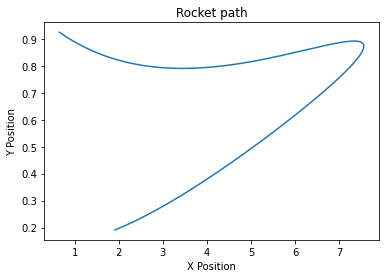

[10] loss: 1.165


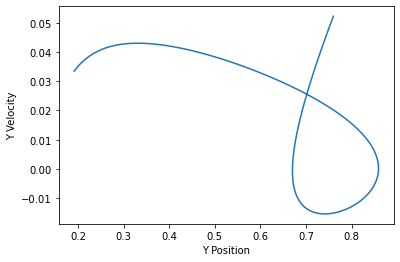

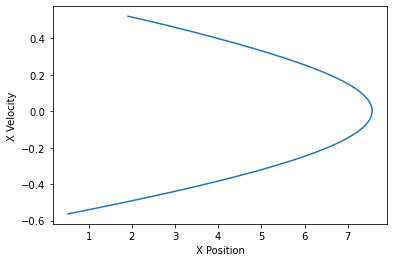

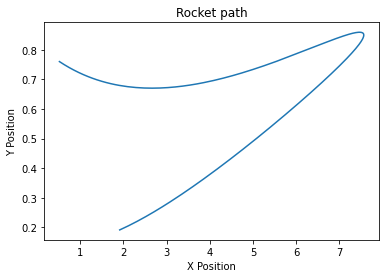

[11] loss: 0.898


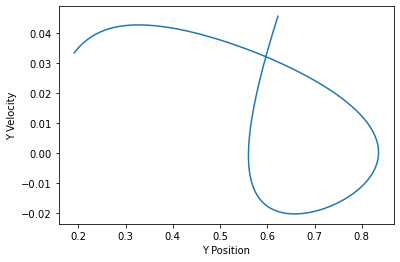

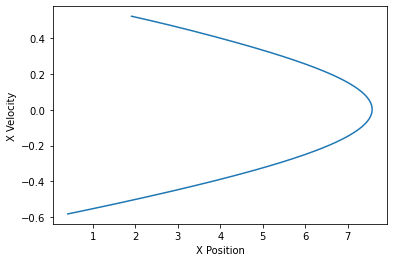

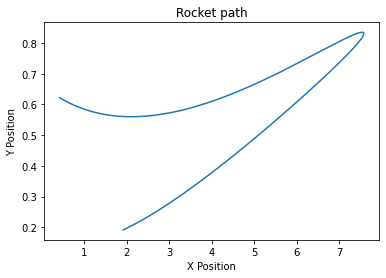

[12] loss: 0.725


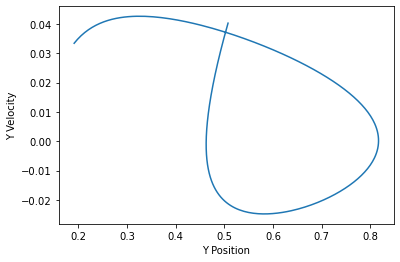

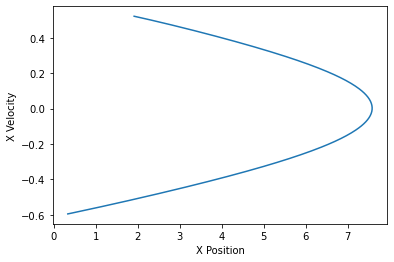

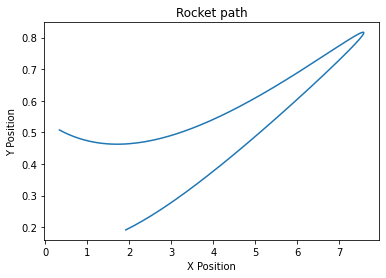

[13] loss: 0.615


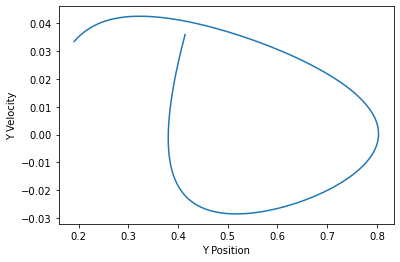

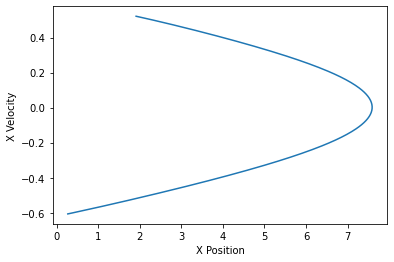

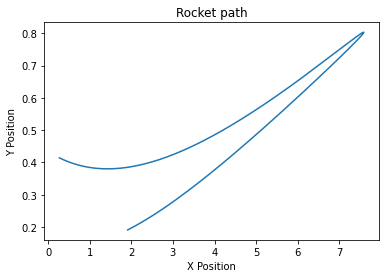

[14] loss: 0.546


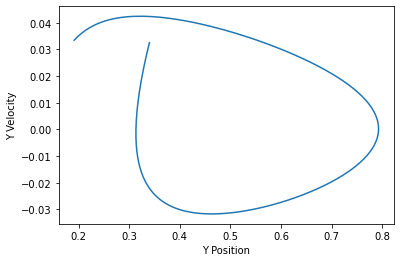

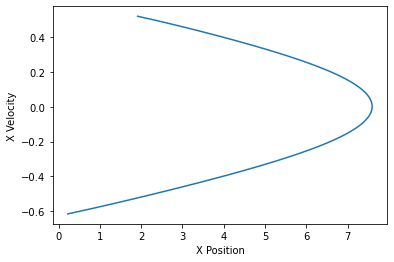

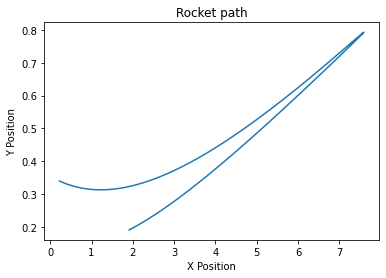

[15] loss: 0.503


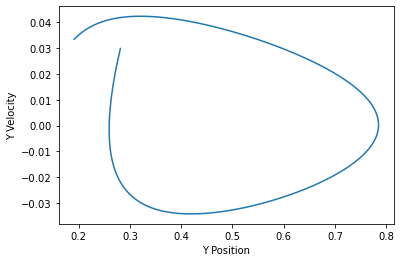

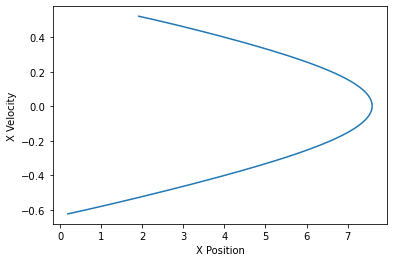

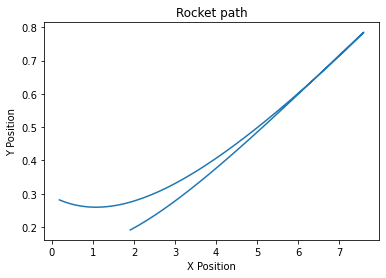

[16] loss: 0.476


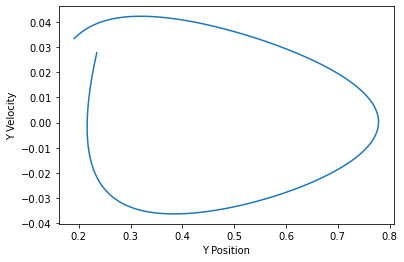

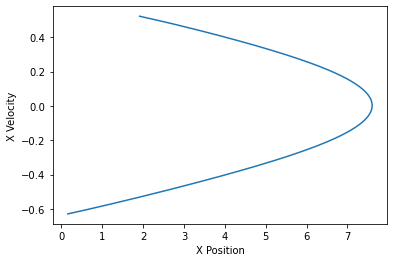

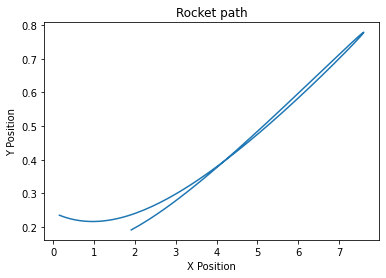

[17] loss: 0.459


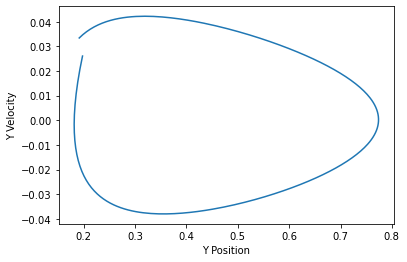

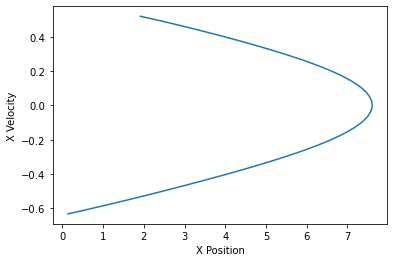

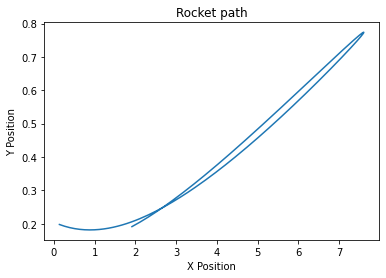

[18] loss: 0.448


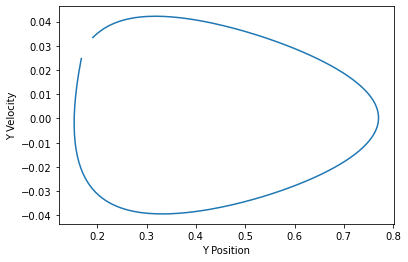

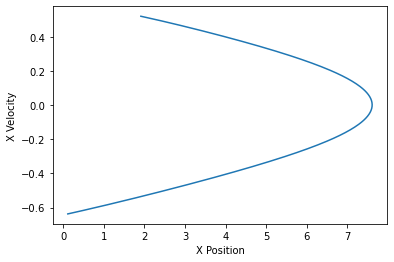

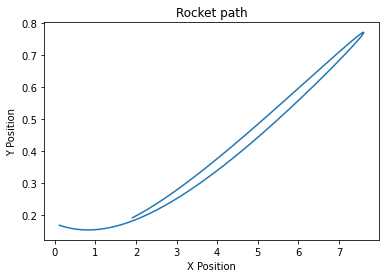

[19] loss: 0.441


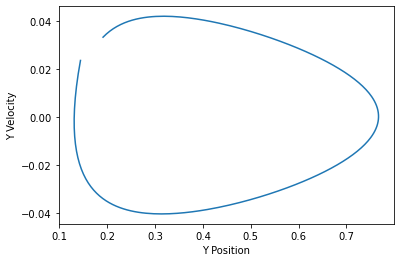

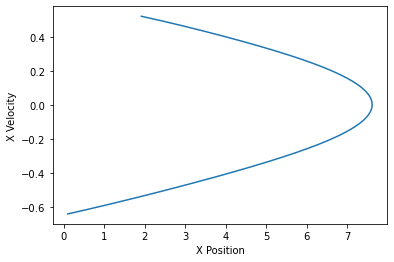

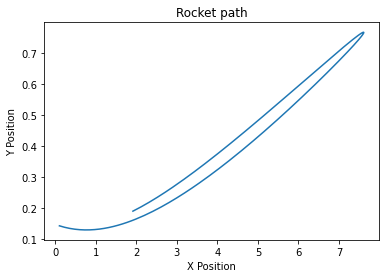

[20] loss: 0.437


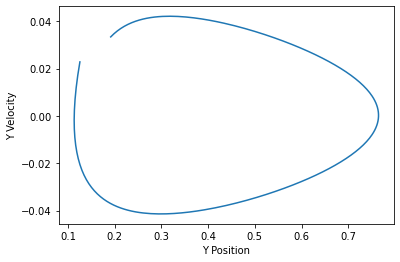

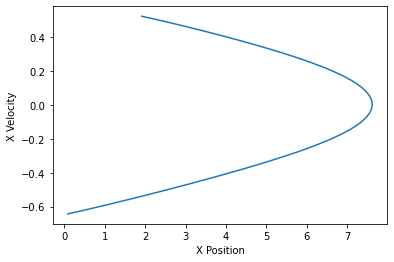

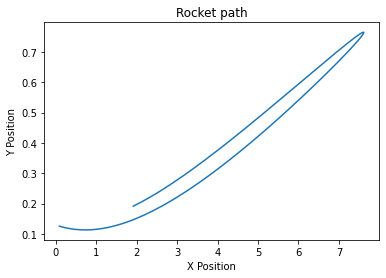

[21] loss: 0.434


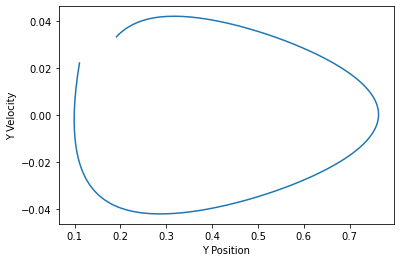

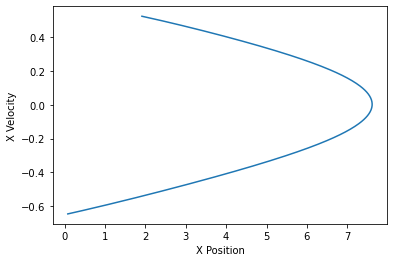

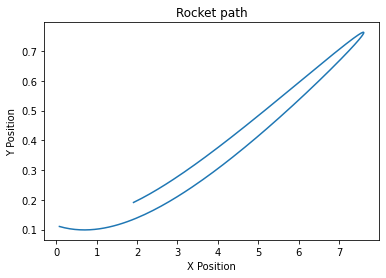

[22] loss: 0.433


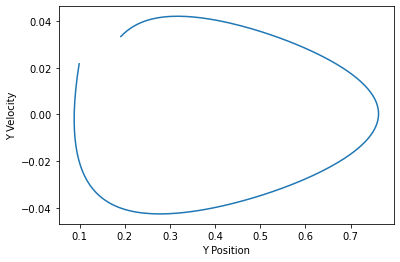

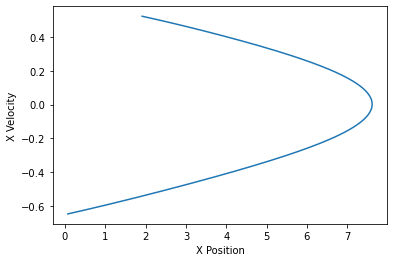

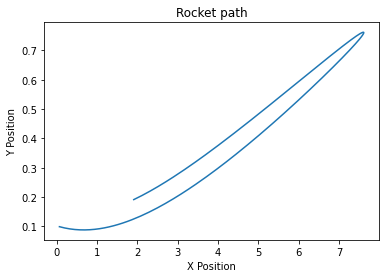

[23] loss: 0.432


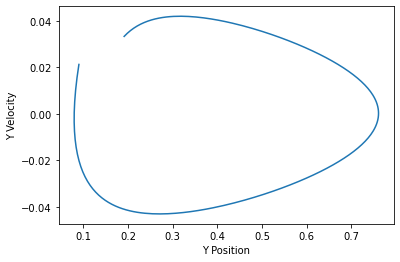

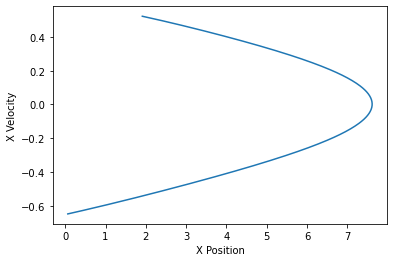

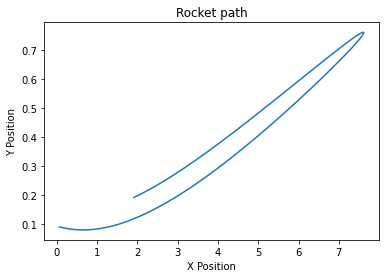

[24] loss: 0.431


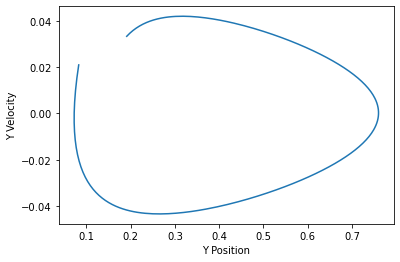

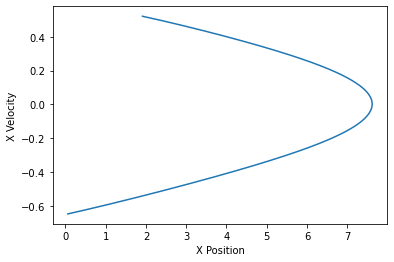

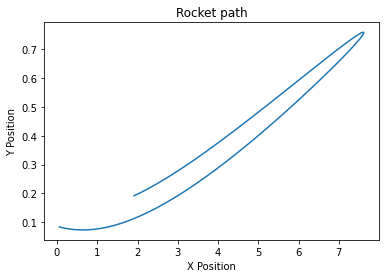

[25] loss: 0.431


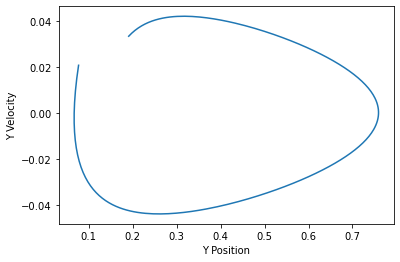

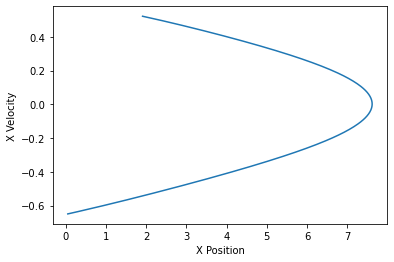

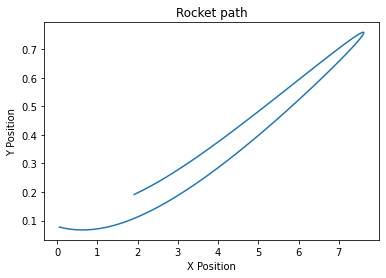

[26] loss: 0.430


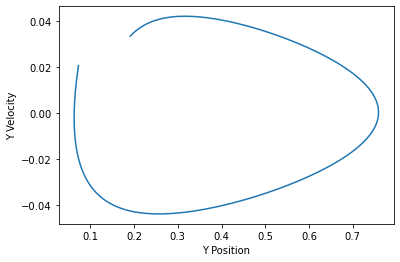

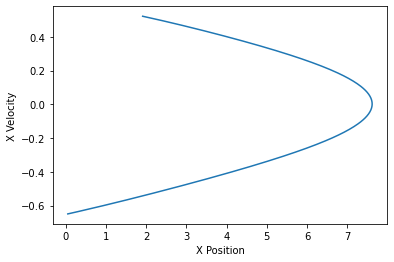

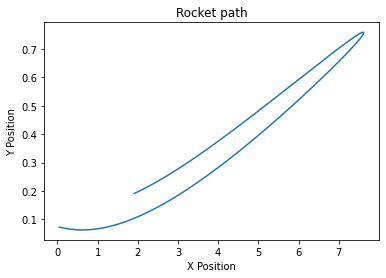

[27] loss: 0.430


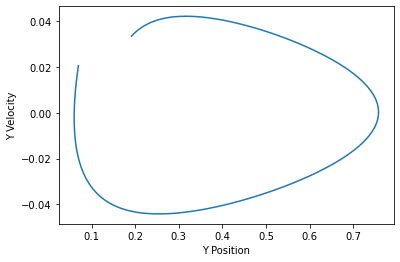

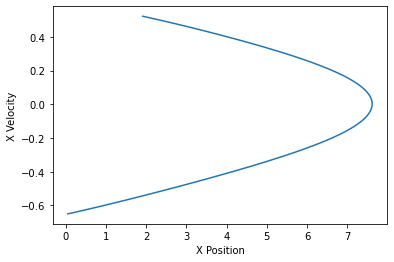

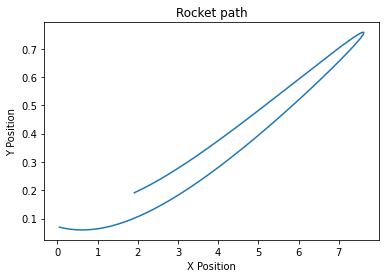

[28] loss: 0.430


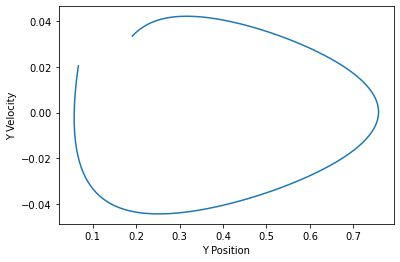

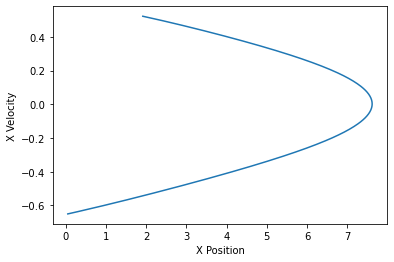

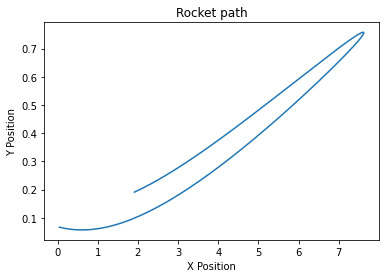

[29] loss: 0.430


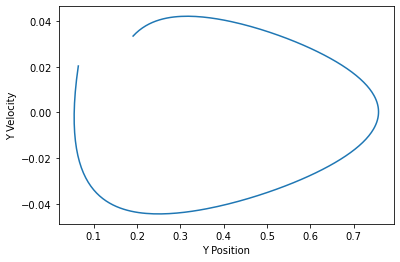

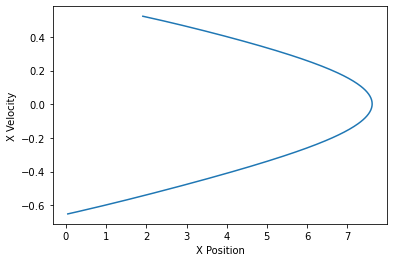

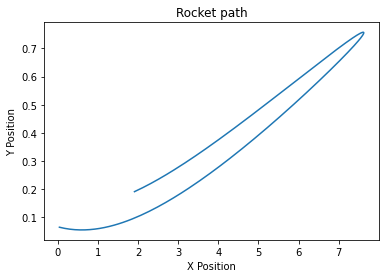

[30] loss: 0.430


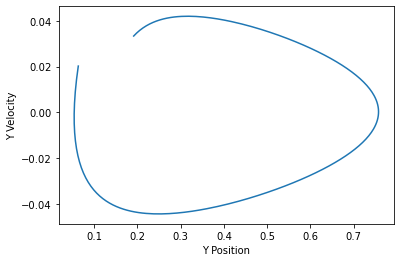

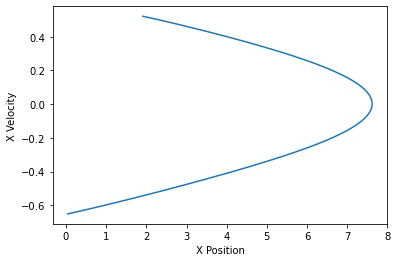

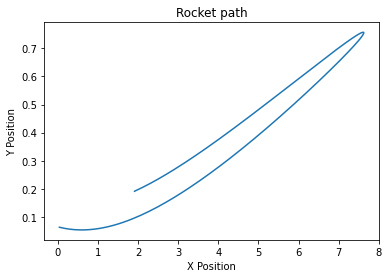

[31] loss: 0.430


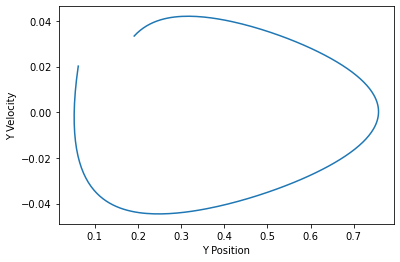

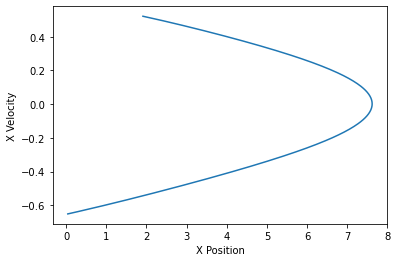

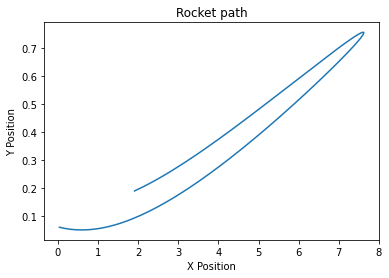

[32] loss: 0.430


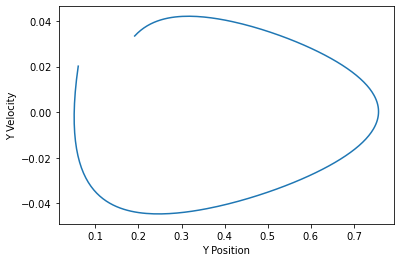

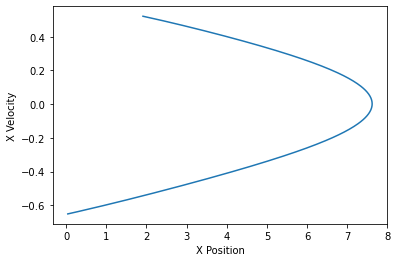

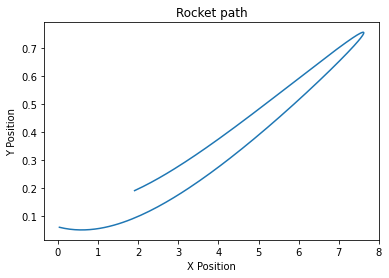

[33] loss: 0.430


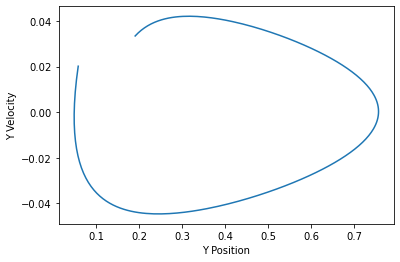

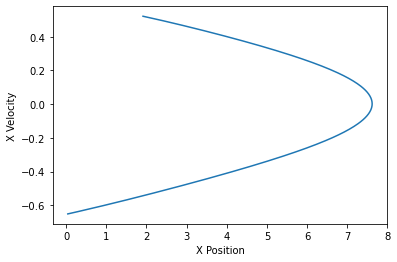

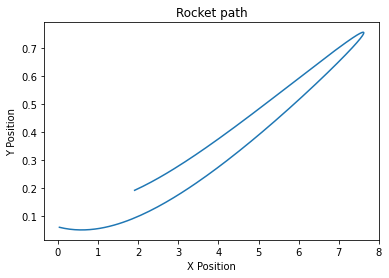

[34] loss: 0.430


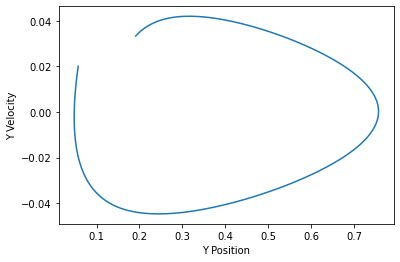

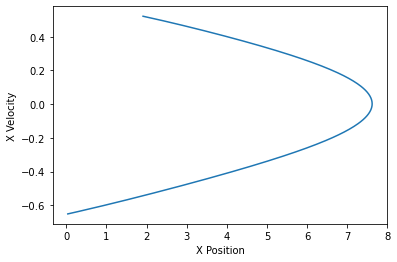

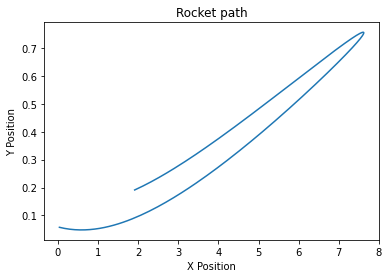

[35] loss: 0.430


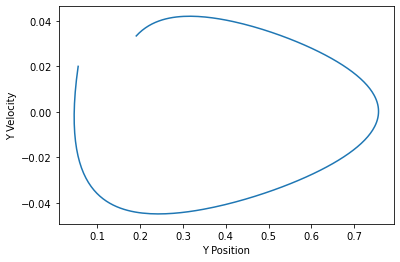

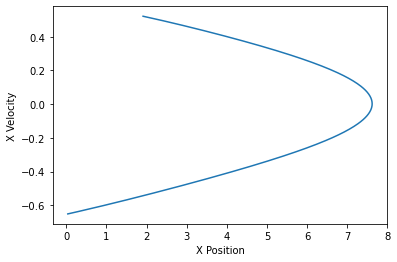

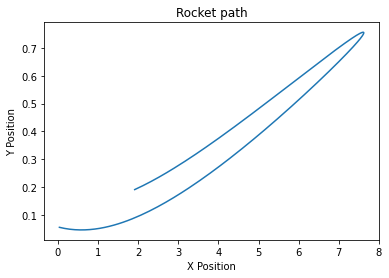

[36] loss: 0.430


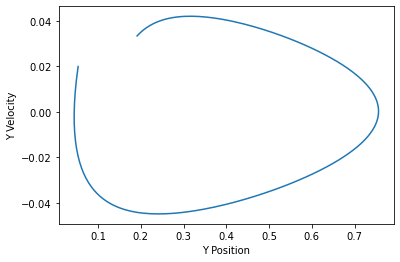

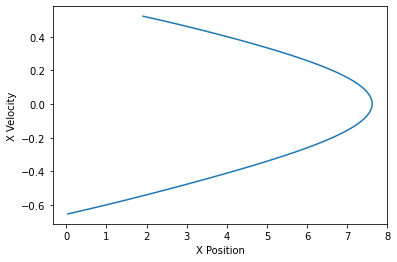

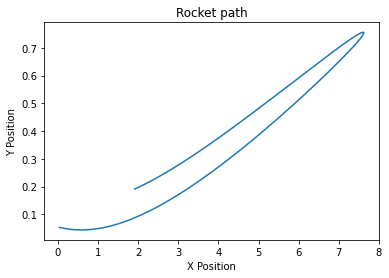

[37] loss: 0.429


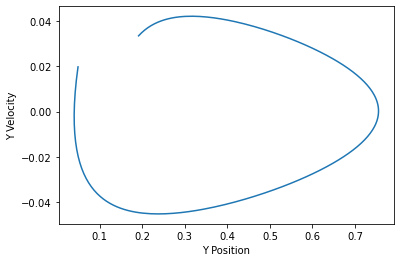

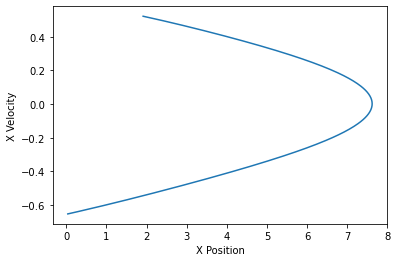

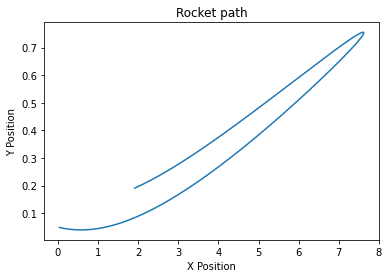

[38] loss: 0.429


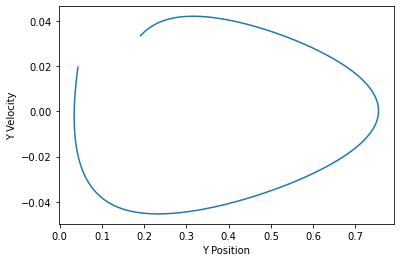

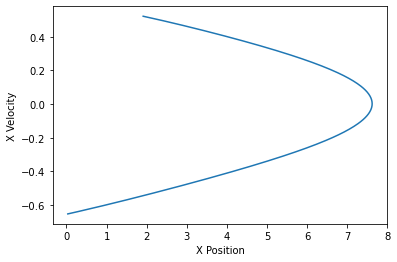

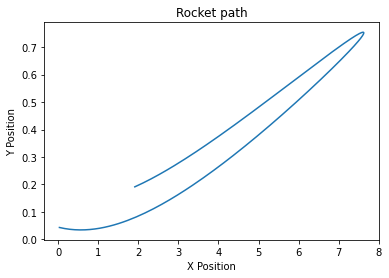

[39] loss: 0.428


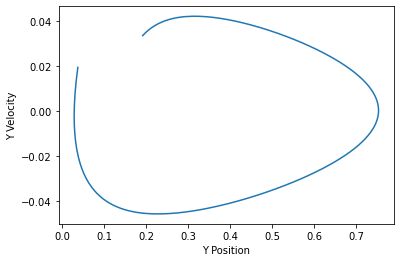

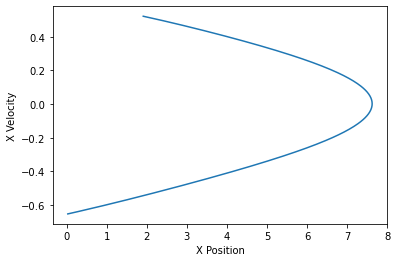

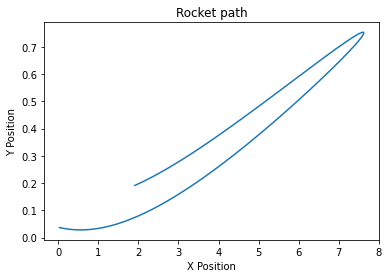

[40] loss: 0.427


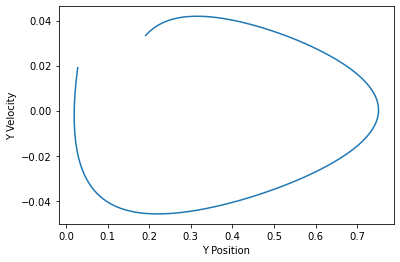

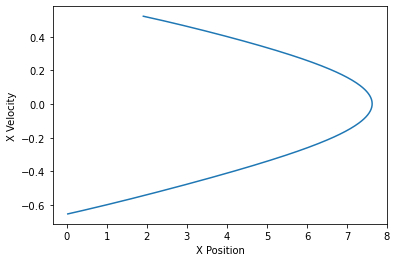

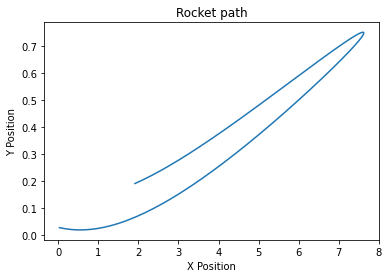

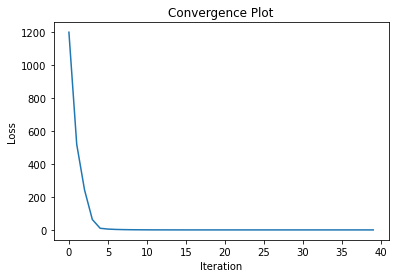

In [731]:
# Now it's time to run the code!

T = 250  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)


In this project i added the effects of wind on the system as well as drag and also introduced a penatly function for the y direction so that the rocket would not crash into the ground. I also randomized the Initial conditions and modeled a rocket with a thruster for each direction except for down.

## 3. A Better Problem Formulation

Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1. More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. 
2. Better dynamical model, e.g., drag
3. Constraints in state and action spaces
4. Controller design for a distribution of initial states rather than one
5. Randomness in dynamics, sensing, etc.
6. Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.

In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized. 

## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 